In [1]:
from IPython.display import display, Math, HTML, Image
import orbits

display(HTML("<h1>NGC 6397</h1>"))
# display(Image(url='https://upload.wikimedia.org/wikipedia/commons/9/99/P0321a.jpg', width=1024))

display(Math('\\text{{RA}} = {}^{{\\circ}}'.format(orbits.RA)))
display(Math('\\text{{DEC}} = {}^{{\\circ}}'.format(orbits.DEC)))
display(Math('\\mu_\\alpha \\cos\\delta = {} \\pm {}^{{\\circ}}'.format(*orbits.PMRA)))
display(Math('\\delta = {} \\pm {}^{{\\circ}}'.format(*orbits.PMDEC)))
display(Math('R_\\odot = {}\\text{{ kpc}}'.format(orbits.RSUN)))
display(Math('\\sigma = {}\\text{{ mas/yr}}'.format(orbits.SIGMA)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [2]:
import gaia
import numpy as np

display(Math('N_\\text{{initial}} = {}'.format(len(gaia.data))))

<IPython.core.display.Math object>

In [3]:

# Clean out bad data
cut = gaia.data['bp_rp'] != 0

display(HTML('Cleaning for zero BP-RP'))
display(Math('N_\\text{{clean}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

In [4]:

# Perform a proper motion cut
cut &= np.abs(gaia.data['pmra'] - orbits.PMRA[0]) < (2 * gaia.data['pmra_error'])
cut &= np.abs(gaia.data['pmdec'] - orbits.PMDEC[0]) < (2 * gaia.data['pmdec_error'])


display(HTML('Proper motion cut'))
display(Math('\\mu_\\alpha \\cos\\delta_i - \\mu_\\alpha \\cos\\delta < 2 \\epsilon_{{\\mu_\\alpha \\cos\\delta_i}}'))
display(Math('\\mu_{\\delta_i }- \\mu_{\\delta} < 2 \\epsilon_{{\\mu_{\\delta_i}}}'))
display(Math('N_\\text{{pm}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:

# Perform a statistical selection
chi2 = 5
cut &= (gaia.data['pmra'] - orbits.PMRA[0])**2 / (orbits.SIGMA**2 + gaia.data['pmra_error']**2) + \
       (gaia.data['pmdec'] - orbits.PMDEC[0])**2 / (orbits.SIGMA**2 + gaia.data['pmdec_error']**2) <= chi2


display(HTML('Statistical criterion cut'))
display(Math('''\\chi^2 = \\frac{(\\mu_\\alpha \\cos\\delta_i - \\mu_\\alpha \\cos\\delta)^2}{(\\sigma^2 + \\epsilon_{{\\mu_\\alpha \\cos\\delta_i}})^2} + \\
                \\frac{(\\mu_{\\delta_i} - \\mu_{\\delta_i})^2}{(\\sigma^2 + \\epsilon_{{\\mu_{\\delta_i}}})^2} \\le 5''')) 
display(Math('N_{{\\chi^2}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:

# Perform a colour-magnitude cut
from scipy import stats
from geom import angular_dist, deg2rad

# Seperate the cluster into inside 0.5 degree radius and outside.
distances = angular_dist(gaia.data['ra'], gaia.data['dec'], orbits.RA, orbits.DEC)
inside = distances < deg2rad(0.5)

# Find all of the faint stars (mag > 20.1) 
faint = gaia.data['phot_g_mean_mag'] > 20.1
bright = gaia.data['phot_g_mean_mag'] < 19

# Of the stars outside the 0.5 deg radius, determine if
# the angular separation is of the same distribution.
g1 = cut & ~inside & faint
g2 = cut & ~inside & ~faint
result = stats.kstest(distances[g1], distances[g2])

# If reasonably certain the two groups are different,
# throw away the faint ones.
if result.pvalue < 0.05:
    cut &= ~g1


display(HTML('Final selection'))
display(Math('N_\\text{{final}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

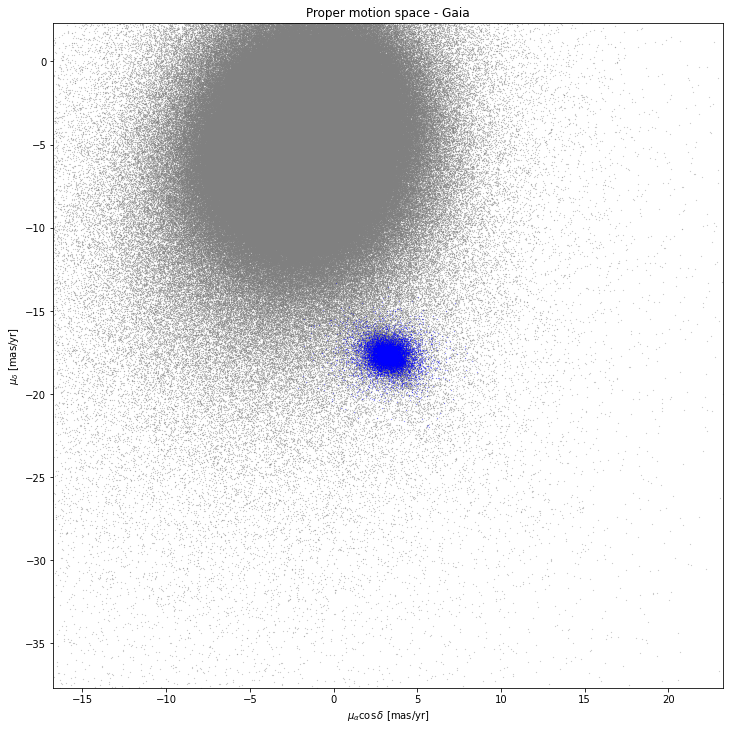

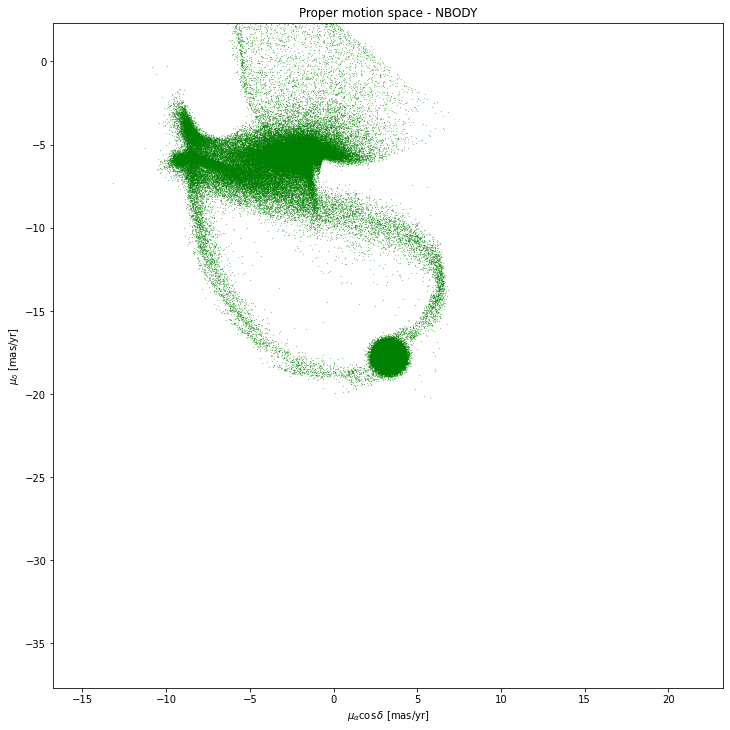

In [7]:
from astropy.visualization import quantity_support
quantity_support()  
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12, 12]
mpl.rcParams['figure.dpi'] = 72

# Draw a proper motion diagram.
fig, ax = plt.subplots(ncols=1)

ax.set(
    title=r'Proper motion space - Gaia',
    xlim=[orbits.PMRA[0]-20, orbits.PMRA[0]+20],
    ylim=[orbits.PMDEC[0]-20, orbits.PMDEC[0]+20]
)
ax.set_xlabel(r'$\mu_{\alpha} \cos \delta$ [mas/yr]')
ax.set_ylabel(r'$\mu_{\delta}$ [mas/yr]')

# Stars outside the proper motion space
ax.scatter(gaia.data['pmra'][~cut], gaia.data['pmdec'][~cut], color='gray', s=0.1, marker='.')

# Stars inside the proper motion space
ax.scatter(gaia.data['pmra'][cut], gaia.data['pmdec'][cut], color='b', s=0.1, marker='.')


# Draw a PM diagram for nbody
nbody = np.loadtxt('ngc6397.out')
fig, ax = plt.subplots(ncols=1)

ax.set(
    title=r'Proper motion space - NBODY',
    xlim=[orbits.PMRA[0]-20, orbits.PMRA[0]+20],
    ylim=[orbits.PMDEC[0]-20, orbits.PMDEC[0]+20]
)
ax.set_xlabel(r'$\mu_{\alpha} \cos \delta$ [mas/yr]')
ax.set_ylabel(r'$\mu_{\delta}$ [mas/yr]')

# Stars inside the proper motion space
ax.scatter(nbody[:,4], nbody[:,5], color='g', s=0.1, marker='.')



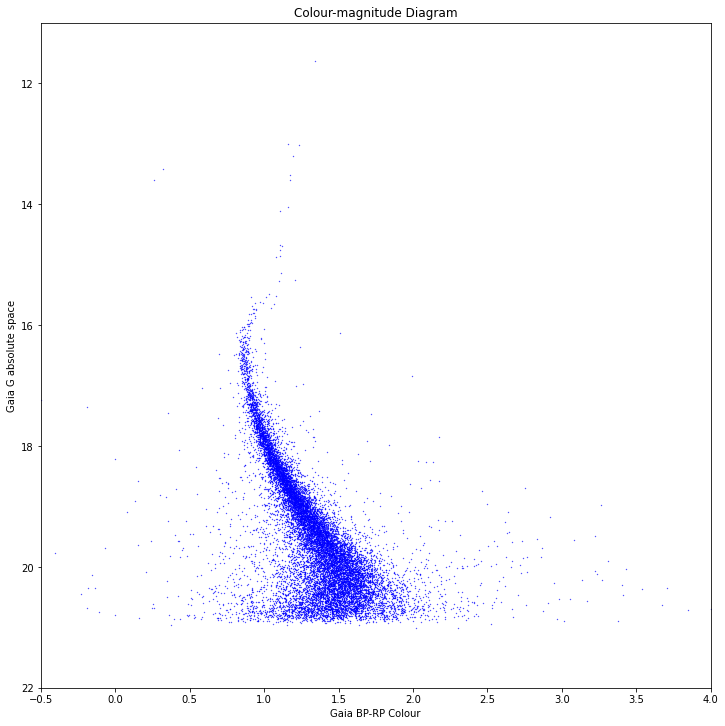

In [8]:
# Draw a colour-magnitude diagram

fig, ax = plt.subplots(ncols=1)
ax.invert_yaxis()
ax.set_xlabel('Gaia BP-RP Colour')
ax.set_ylabel('Gaia G absolute space')
ax.set(
    title=r'Colour-magnitude Diagram',
    xlim=[-0.5, 4.0],
    ylim=[22, 11]
)

#ax.scatter(gaia.data['bp_rp'][~cut], gaia.data['phot_g_mean_mag'][~cut], color='gray', marker='x', s=0.1)
ax.scatter(gaia.data['bp_rp'][cut], gaia.data['phot_g_mean_mag'][cut], color='b', s=0.1)


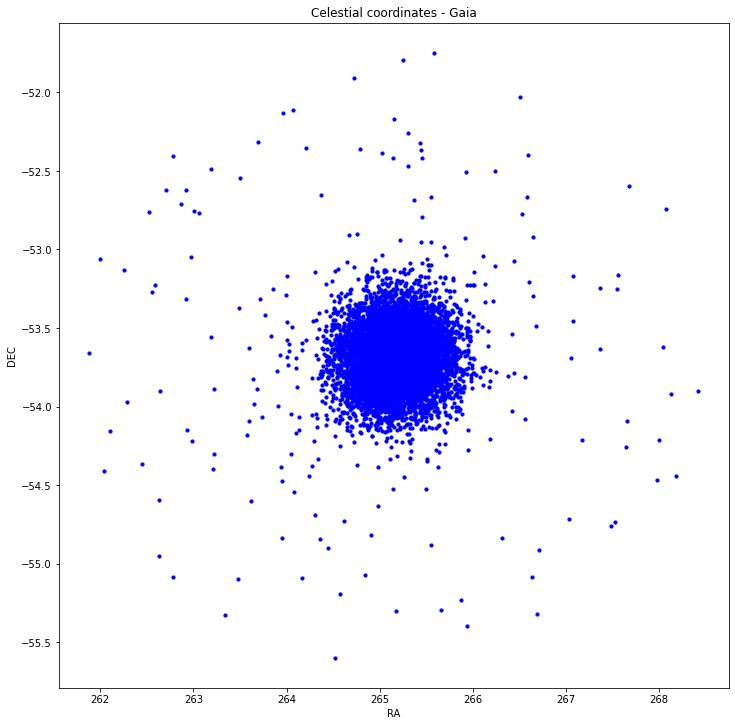

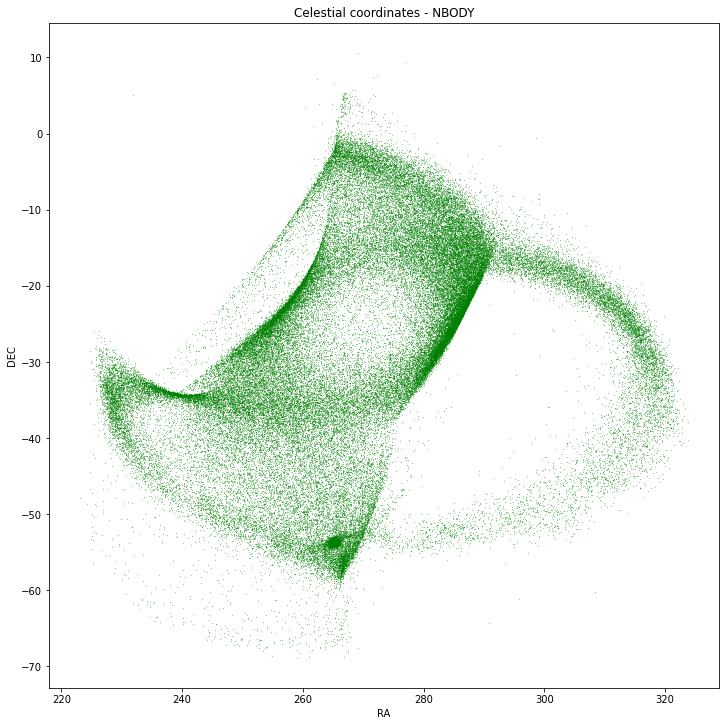

In [9]:

# Plot the spatial coordinates
fig, ax = plt.subplots(ncols=1)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Celestial coordinates - Gaia')
ax.scatter(gaia.data['ra'][cut], gaia.data['dec'][cut], color='b', marker='o', s=10)


fig, ax = plt.subplots(ncols=1)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Celestial coordinates - NBODY')
ax.scatter(nbody[:,1], nbody[:,2], color='g', marker='.', s=0.1)



In [10]:
def sdens_to_sb(n):
    return (-2.5) * np.log10(n)

def surface_density(d, ax, label, scale=17, fmt='none', lw=2):
    logmin = np.amin(d)
    logmax = np.amax(d)
    logbins = np.logspace(np.log10(logmin), np.log10(logmax), 50)
    counts, bins = np.histogram(d, bins=logbins)
    cut = counts > 0
    
    # Divide the sum in each bin by the area of the annulus
    r_b = bins[:-1]
    area = np.array([
      2 * np.pi * bins[i+1] * (bins[i+1] - r)
      for i,r in enumerate(r_b)
    ])[cut]
    
    n_area = counts[cut] / area 
    nsq_area = np.sqrt(counts[cut]) / area 
    error = np.log10(n_area + nsq_area) - np.log10(n_area)
    
    ax.errorbar(r_b[cut], sdens_to_sb(n_area)+scale, fmt=fmt,
                yerr=np.abs(error), label=label, lw=lw, elinewidth=2)
    


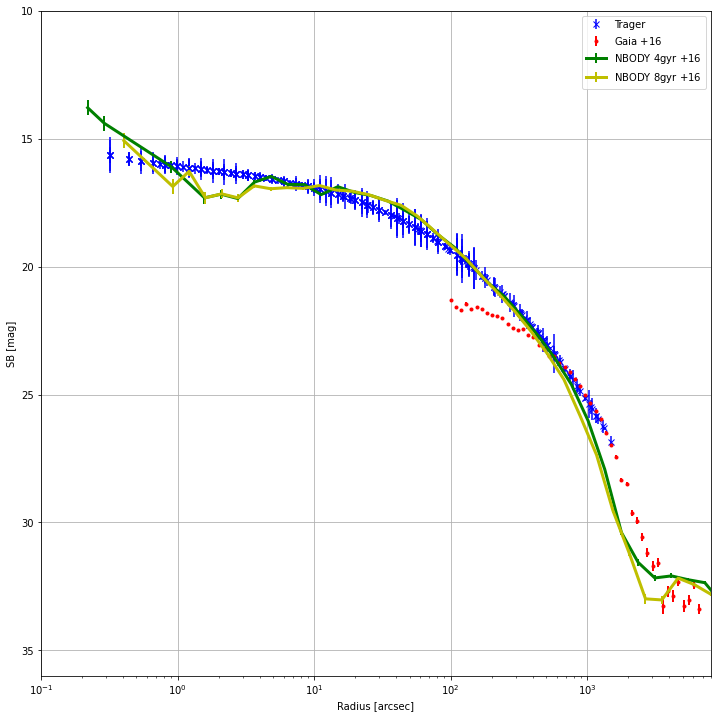

In [11]:
# Stitch with Trager et al.
from geom import rad2arcsec
trager = np.loadtxt('ngc6397_trager.dat')

fig, ax = plt.subplots(ncols=1)

ax.set_xlabel(r'Radius [arcsec]')
ax.set_ylabel(r'SB [mag]')
ax.set_xscale("log")
ax.grid()
ax.invert_yaxis()
ax.set(
    ylim=[36, 10],
    xlim=[0.1, 8000]
)
# ax.set(title="Surface Density")

# Plot tager
# ax.plot(10**trager[:,0], trager[:,2], label='Trager')
trager_err = np.abs(trager[:,3])
cut_trager = trager_err < 1
ax.errorbar(10**trager[:,0][cut_trager], trager[:,2][cut_trager], yerr=trager_err[cut_trager], label='Trager', fmt='bx')


# Stitch Gaia
cut = cut & bright
gaia_cut = gaia.data[cut]
arcsec_distance = rad2arcsec(angular_dist(gaia_cut['ra'], gaia_cut['dec'], orbits.RA, orbits.DEC))
surface_density(arcsec_distance[arcsec_distance > 100], ax, 'Gaia $+16$', scale=16, fmt='r.')

# Get nbody form
m80 = (nbody[:,7] > 0.8) & (nbody[:,8] < 10)

nbdis = rad2arcsec(angular_dist(nbody[:,1][m80], nbody[:,2][m80], orbits.RA, orbits.DEC))
surface_density(nbdis, ax, 'NBODY 4gyr $+16$', fmt='g-', scale=16, lw=3)

# Get nbody form
nbody8 = np.loadtxt('8gyr/ngc6397.out')
m80 = (nbody8[:,7] > 0.8) & (nbody8[:,8] < 10)

nbdis = rad2arcsec(angular_dist(nbody8[:,1][m80], nbody8[:,2][m80], orbits.RA, orbits.DEC))
surface_density(nbdis, ax, 'NBODY 8gyr $+16$', fmt='y-', scale=16, lw=3)


ax.legend()

18.753123748248843 km / s


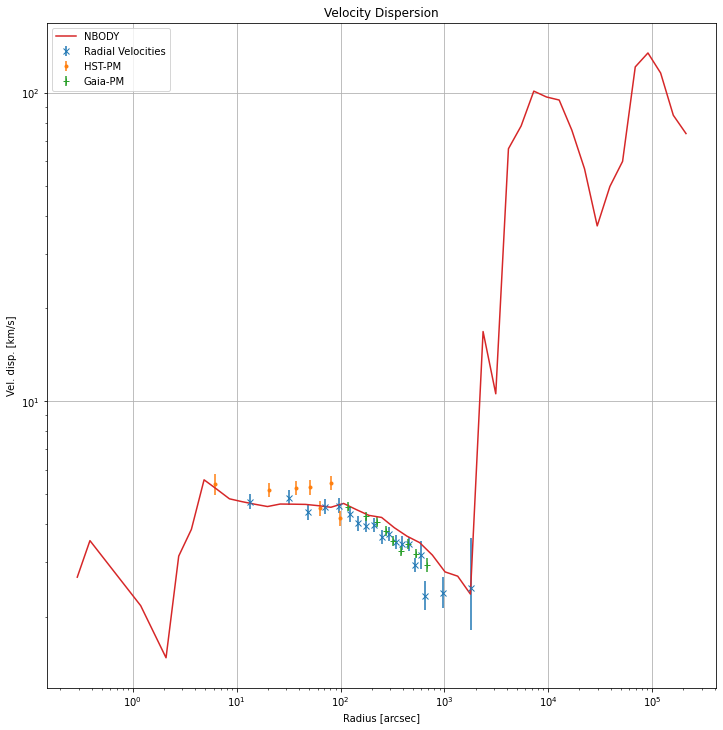

In [42]:
# Vel. disp.
from astropy import units as u
import veldis

fig, ax = plt.subplots(ncols=1)
ax.set_xlabel(r'Radius [arcsec]')
ax.set_ylabel(r'Vel. disp. [km/s]')
ax.set_title('Velocity Dispersion')
ax.set_xscale("log")
ax.set_yscale('log')
ax.grid()
#ax.set(
#    xlim=[30, 1.0e3]
#)


#ax.set(
#    xlim=[1e2, 1e3]
#)


def nb_veldis():
    
    m80 = (nbody[:,7] > 0.8) & (nbody[:,8] < 10)
    bright = nbody[m80]
    nbv = bright[:,6] * u.km/u.s
    nbdis = rad2arcsec(angular_dist(bright[:,1], bright[:,2], orbits.RA, orbits.DEC)) * u.arcsec
    
    nbinner = nbdis.to(u.parsec, equivalencies=u.parallax()) < 10*u.parsec
    nb_v_avg = np.average(nbv[nbinner])
    print(nb_v_avg)
    #sig2 = 1 / len(nbv) * sum((v - nb_v_avg)**2 for v in nbv)

    logmin = np.amin(nbdis)
    logmax = np.amax(nbdis)
    logbins = np.logspace(np.log10(logmin.value), np.log10(logmax.value))
    
    ll = 0 * u.arcsec
    hist = []
    bins = []
    for lr in logbins:
        bds = (nbdis >= ll) & (nbdis < lr * u.arcsec) 
        if any(bds):
            hist.append(
                np.sqrt(1 / np.sum(bds) * np.sum((nbv[bds] - nb_v_avg)**2))/u.km*u.s
            )
            bins.append(lr)
        ll = lr * u.arcsec
        
    return hist, bins


def plot_veldis_type(ax, t, label, fmt='.'):
    vcut = veldis.odata['type'] == t
    verru = veldis.odata['esig_u'][vcut]
    verrl = veldis.odata['e_sigl'][vcut]
    verr = np.vstack((verrl, verru))
    ax.errorbar(veldis.odata['R'][vcut], veldis.odata['sig'][vcut], verr, label=label, fmt=fmt)

plot_veldis_type(ax, 1, 'Radial Velocities', fmt='x')
plot_veldis_type(ax, 2, 'HST-PM', fmt='.')
plot_veldis_type(ax, 4, 'Gaia-PM', fmt='+')


nbvd, nbvb = nb_veldis()
ax.plot(nbvb, nbvd, label='NBODY')
ax.legend()


